In [2]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from tqdm import tqdm
import torch

# EDA

In [3]:
data = pd.read_csv('data/all_data_no_emoticon.csv', header=None, encoding = "ISO-8859-1")

In [4]:
data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Class distribution

<Axes: >

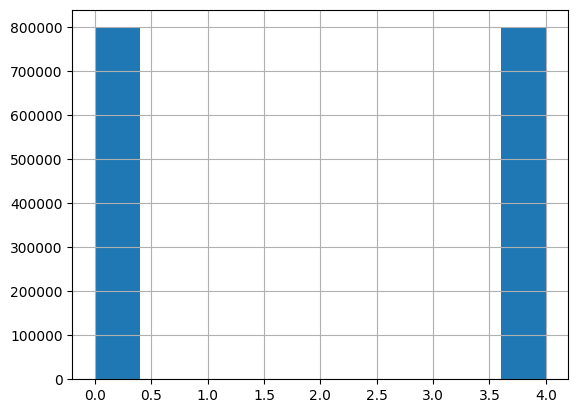

In [5]:
data[0].hist()

In [6]:
data[0] = data[0].replace(4, 1)

<Axes: >

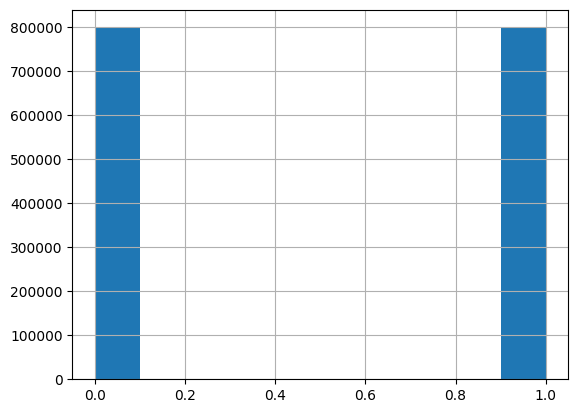

In [7]:
data[0].hist()

# Data cleaning

In [8]:
data = data[[0, 5]]
data.columns = ['sentiment', 'text']

In [9]:
data

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
data['text'] = data['text'].str.replace(r'http\S+', '', regex=True)
data['text'] = data['text'].str.replace(r'@\S+', '', regex=True)
data['text'] = data['text'].str.lower()
data['text'] = data['text'].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()


/var/folders/7z/5pqw1rcn15ndv5kn7c_qsk0w0000gn/T/ipykernel_3389/1409543789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].str.replace(r'http\S+', '', regex=True)
/var/folders/7z/5pqw1rcn15ndv5kn7c_qsk0w0000gn/T/ipykernel_3389/1409543789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].str.replace(r'@\S+', '', regex=True)
/var/folders/7z/5pqw1rcn15ndv5kn7c_qsk0w0000gn/T/ipykernel_3389/1409543789.py:3: SettingWithCopyWarning: 
A value is trying t

In [11]:
data

,sentiment,text
0,0,"- awww, that's a bummer. you shoulda got david..."
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball. managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am ..."
...,...,...
1599995,1,just woke up. having no school is the best fee...
1599996,1,thewdb.com - very cool to hear old walt interv...
1599997,1,are you ready for your mojo makeover? ask me f...
1599998,1,happy 38th birthday to my boo of alll time!!! ...


In [29]:
data.to_csv('data/all_data_clean.csv', index=False)

# Tokenize and Embedding with BERT

In [12]:
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def tokenize_sentences(sentences, max_length=140):
    input_ids = []
    attention_masks = []

    for sentence in tqdm(sentences):
        encoded_dict = tokenizer.encode_plus(
            sentence,                    
            add_special_tokens=True,    
            max_length=max_length,
         
            pad_to_max_length=True,
            return_attention_mask=True, 
            return_tensors='pt',       
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

In [14]:
input_ids, attention_masks = tokenize_sentences(data['text'])

  0%|          | 0/1600000 [00:00<?, ?it/s]/Users/will/mambaforge/envs/cs505/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1600000/1600000 [02:22<00:00, 11203.27it/s]


In [15]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [19]:
def get_embeddings(model, input_ids, attention_masks, batch_size=512):
    model.eval()
    embeddings = []

    for i in tqdm(range(0, input_ids.size(0), batch_size)):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]

        with torch.no_grad():
            batch_embeddings = model(batch_input_ids, attention_mask=batch_attention_masks)
            embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy()) 

    return np.concatenate(embeddings, axis=0)

In [32]:
def get_embeddings(model, input_ids, attention_masks, batch_size=128):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    model.eval()
    embeddings = []

    for i in tqdm(range(0, input_ids.size(0), batch_size)):
        batch_input_ids = input_ids[i:i+batch_size].to(device)
        batch_attention_masks = attention_masks[i:i+batch_size].to(device)

        with torch.no_grad():
            batch_embeddings = model(batch_input_ids, attention_mask=batch_attention_masks)
            embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())
    return np.concatenate(embeddings, axis=0)

In [33]:
cls_embeddings = get_embeddings(model, input_ids, attention_masks)

embeddings_df = pd.DataFrame(cls_embeddings)

embeddings_df['sentiment'] = data['sentiment'].values

Using device: mps


100%|██████████| 12500/12500 [1:31:23<00:00,  2.28it/s]


In [34]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,sentiment
0,-0.077179,0.053418,0.023063,-0.106650,0.076572,-0.085231,-0.042386,0.004496,0.101149,-0.078086,...,0.025755,-0.106748,-0.057218,0.033696,0.102764,0.091364,-0.127808,-0.049439,-0.023809,0
1,-0.043509,0.060965,-0.012606,-0.116886,0.098542,-0.137686,-0.031998,-0.009975,0.064352,-0.071121,...,0.006059,-0.080860,-0.114923,0.025331,0.123183,0.102260,-0.110067,-0.056861,0.026642,0
2,-0.057773,0.072403,-0.033022,-0.115374,0.040808,-0.072422,-0.053605,0.040743,0.076706,-0.045080,...,-0.020417,-0.099441,-0.084790,-0.002279,0.121157,0.083297,-0.103949,-0.050733,-0.018452,0
3,-0.031709,0.067412,-0.030389,-0.112123,0.053672,-0.114905,-0.033388,0.011017,0.089351,-0.043932,...,-0.024586,-0.064485,-0.124869,-0.004122,0.146368,0.118158,-0.109887,-0.065156,-0.037488,0
4,-0.117890,0.083077,0.011466,-0.142559,0.080581,-0.113307,-0.040810,0.036910,0.104385,-0.040741,...,0.046208,-0.099468,-0.073672,0.027816,0.100077,0.128643,-0.105009,-0.049872,-0.027503,0


In [35]:
embeddings_df.shape

(1600000, 769)

In [37]:
embeddings_array = embeddings_df.to_numpy()


In [38]:
np.save('embeddings_with_labels.npy', embeddings_array)

In [39]:
from sklearn.model_selection import train_test_split

embeddings_array = embeddings_df.to_numpy()
train_data, test_data = train_test_split(embeddings_array, test_size=0.2, random_state=42)
np.save('train_bert_embeddings_with_labels.npy', train_data)
np.save('test_bert_embeddings_with_labels.npy', test_data)

In [45]:
import matplotlib.pyplot as plt

In [49]:
train_data.shape, test_data.shape

((1280000, 769), (320000, 769))

### Double check train test data class distribution

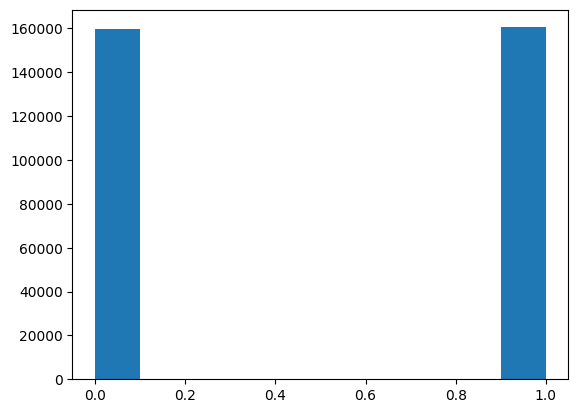

In [51]:
plt.hist(test_data[:, -1]);

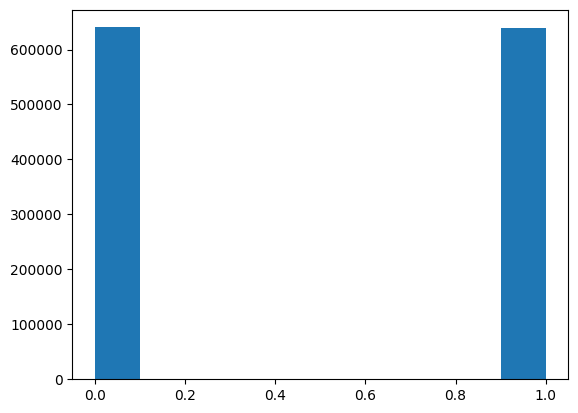

In [52]:
plt.hist(train_data[:, -1]);